# Machine Learning Engineer Nanodegree
## Credit Card Fraud Detection Model

## Import Libraries

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, make_scorer, confusion_matrix
from time import time
from __future__ import division
import itertools
from IPython.display import display # Allows the use of display() for DataFrames
import visuals as vs


%matplotlib inline

## Helper Methods

In [ ]:
def data_prepration(data): 
    X= data.iloc[:,data.columns != "Class"]
    y= data.iloc[:,data.columns=="Class"]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
    return(X_train,X_test,y_train,y_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Import supplementary visualization code visuals.py

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    # Compute precision on the training samples 
    results['auprc_train'] = average_precision_score(y_train,predictions_train)
    
    # Compute cross validation on the training set 
    auprc_scorer = make_scorer(average_precision_score)
    
    # Reshape the labels due to an indexing glitch
    a,b = y_train.shape
    y_train = y_train.iloc[0:,0].values.reshape(a,)
    
    results['auprc_cv'] = cross_val_score(learner, X_train, y_train,cv=3, scoring = auprc_scorer).mean()
        
    # Compute cross validation on the training set 
    recall_scorer = make_scorer(recall_score)
    results['recall_cv'] = cross_val_score(learner, X_train, y_train,cv=3, scoring = recall_scorer).mean()

    # Compute recall on the training samples 
    results['recall_train'] = recall_score(y_train,predictions_train)
        
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

## Load the data

In [3]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Data Analysis and Visualization

### Showing the ratio of classes

('Percentage of normal transactions: ', 0)
('Percentage of fraud transactions: ', 0)
('Total number of transactions in data: ', 284807)


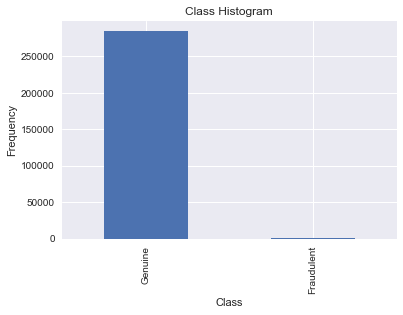

In [4]:
count_of_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_of_classes.plot(kind = 'bar')
plt.title("Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0,1],["Genuine","Fraudulent"])

# Showing ratio
print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

## 2. Data Preprocessing

### Normalizing Numerical Features

In [4]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

data['normalAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normalAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.005824
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.000105
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.014739
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.004807
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.002724


In [5]:
X_train, X_test, y_train, y_test = data_prepration(data)
columns = X_train.columns

### Use SMOTE to balance our dataset

In [6]:
smote_algo = SMOTE(random_state=0)
smote_data_X,smote_data_Y = smote_algo.fit_sample(X_train, y_train)
smote_data_X = pd.DataFrame(data=smote_data_X,columns=columns )
smote_data_Y= pd.DataFrame(data=smote_data_Y,columns=["Class"])
smote_data = smote_data_X
smote_data["Class"] = smote_data_Y["Class"]

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


('Percentage of normal transactions: ', 0)
('Percentage of fraud transactions: ', 0)
('Total number of transactions in balanced data: ', 398022)


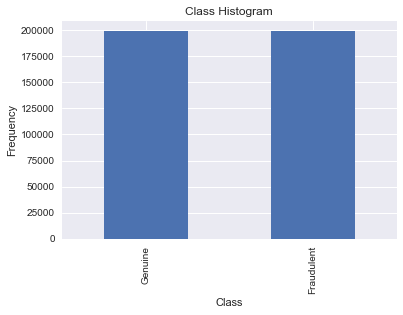

In [99]:
count_of_classes = pd.value_counts(smote_data_Y['Class'], sort = True).sort_index()
count_of_classes.plot(kind = 'bar')
plt.title("Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0,1],["Genuine","Fraudulent"])

# Showing ratio
print("Percentage of normal transactions: ", len(smote_data_Y[smote_data_Y.Class == 0])/len(smote_data_Y))
print("Percentage of fraud transactions: ", len(smote_data_Y[smote_data_Y.Class == 1])/len(smote_data_Y))
print("Total number of transactions in balanced data: ", len(smote_data_Y))

### Split the balanced data into training and test sets

In [7]:
smote_X_train, smote_X_test, smote_y_train, smote_y_test = data_prepration(smote_data)
columns = smote_X_train.columns

## 3. Developing the Model

### Benchmark Model

I built a simple logistic regression classifier, which will serve as the benchmark model for this project.
The Area Under the Precision-Recall Curve (AUPRC) of the benchmark model is 0.71.  
The notebook for the model can be found in the root directory of this project.

### Implementation - Selecting the Most Suitable Model

In [79]:
# Initialize the four models
clf_A = DecisionTreeClassifier(random_state=123)
clf_B = LogisticRegression() 
clf_C = GaussianNB()
clf_D = MLPClassifier(hidden_layer_sizes=(21),random_state=123)

# TODO: Calculate the number of samples for 1%, 10%, 50% and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(smote_y_train)
samples_50 = int(samples_100*0.5)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, smote_X_train, smote_y_train, smote_X_test, smote_y_test)

# evaluation metrics of benchmark model to be compared with the classifiers.
precision_benchmark = 0.83
recall_benchmark = 0.59
auprc_benchmark = 0.71
# Run metrics visualization for the three supervised learning models chosen
# vs.evaluate(results, precision_benchmark, recall_benchmark)

DecisionTreeClassifier trained on 2786 samples.
DecisionTreeClassifier trained on 27861 samples.
DecisionTreeClassifier trained on 139307 samples.
DecisionTreeClassifier trained on 278615 samples.
LogisticRegression trained on 2786 samples.
LogisticRegression trained on 27861 samples.
LogisticRegression trained on 139307 samples.
LogisticRegression trained on 278615 samples.
GaussianNB trained on 2786 samples.
GaussianNB trained on 27861 samples.
GaussianNB trained on 139307 samples.
GaussianNB trained on 278615 samples.
MLPClassifier trained on 2786 samples.
MLPClassifier trained on 27861 samples.
MLPClassifier trained on 139307 samples.
MLPClassifier trained on 278615 samples.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


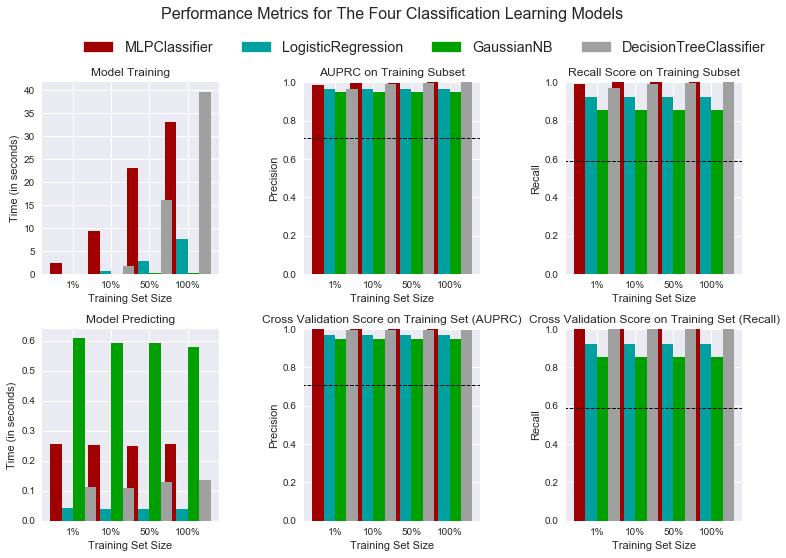

In [81]:
%load_ext autoreload
%autoreload 1
%aimport visuals

visuals.evaluate(results, auprc_benchmark, recall_benchmark)

### Implementation - Logistic Regression Model

In [96]:
LogReg = LogisticRegression()
parameters = {'C': [0.01, 0.1, 1]}
auprc_scorer = make_scorer(average_precision_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=LogReg,param_grid=parameters,scoring=auprc_scorer)

# Reshape the labels due to an indexing glitch
# a,b = smote_y_train.shape
# smote_y_train = smote_y_train.iloc[0:,0].values.reshape(a,)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(smote_X_train,smote_y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# get cv scores using the unoptimized and optimized model
predictions_cv = cross_val_score(LogReg, smote_X_train, smote_y_train,cv=3, scoring = auprc_scorer).mean()
best_predictions_cv = cross_val_score(best_clf, smote_X_train, smote_y_train,cv=3, scoring = auprc_scorer).mean()



In [97]:
# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Cross Validation Score on training data (AUPRC): {:.4f}".format(predictions_cv)
print "\nOptimized Model\n------"
print "Final Cross Validation Score on training data (AUPRC): {:.4f}".format(best_predictions_cv)

Unoptimized model
------
Cross Validation Score on training data (AUPRC): 0.9680

Optimized Model
------
Final Cross Validation Score on training data (AUPRC): 0.9680


## Predicting Fraudulent Transactions in the Test Set using Logisitic Regression


In [100]:
y_pred = best_clf.predict(smote_X_test)
y_true = smote_y_test

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
print('Precision score: {0:0.2f}'.format(
      precision))
print('Recall score: {0:0.2f}'.format(
      recall))

Average precision-recall score: 0.97
Precision score: 0.97
Recall score: 0.92


## Plot the Precision-Recall curve on the Test Set Predictions


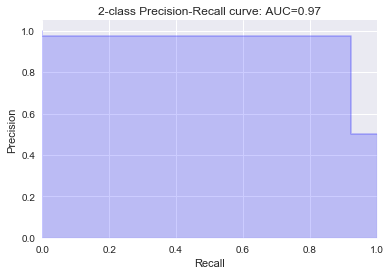

In [102]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

## Plot the Confusion Matrix on the Test Set Predictions


('Recall metric in the test dataset: ', 0.92380043848638516)


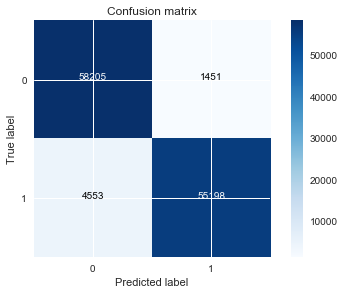

In [116]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the test dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]

plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

